# Finding a, b and c

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from types import SimpleNamespace
from scipy.integrate import odeint

import sys
sys.path.append('src')
#from src.diff_eqs_freqfactor import diff_eqs_freqfactor
from src.plotting import plot_results

## 1. Obtaining training data

Experimental data from simulated TL glow curve using a temperature independent frequency factor.

In [24]:
exp_data = pd.read_csv('ExpData/TLcurve_notemp.csv')
exp_intensity = exp_data['dm_R'].values
exp_temperature = exp_data['Time (s)'].values
exp_time = exp_data['Time (s)'].values

In [25]:
## IMPORTING DATA
# Structural parameters
PathStructural = 'ExpData/ParametrosEstructurales.xlsx'
StructuralData = pd.read_excel(PathStructural, sheet_name='Hoja1', header=0, usecols=None, nrows=None)
# Total density of available positions for traps and Radiative/Non radiative recombination centers (cm-3)
N_I, N_II, N_III, N_IV, N_V, N_s = StructuralData.iloc[[0],[0]].values[0][0],StructuralData.iloc[[1],[0]].values[0][0],StructuralData.iloc[[2],[0]].values[0][0],StructuralData.iloc[[3],[0]].values[0][0],StructuralData.iloc[[4],[0]].values[0][0],StructuralData.iloc[[5],[0]].values[0][0]                    
M_R, M_NR=StructuralData.iloc[[0],[1]].values[0][0],StructuralData.iloc[[0],[2]].values[0][0]
# Electron trapping probability factor for traps and Radiative/Non radiative recombination centers (cm3/s)
A_I, A_II, A_III, A_IV, A_V, A_s = StructuralData.iloc[[0],[3]].values[0][0],StructuralData.iloc[[1],[3]].values[0][0],StructuralData.iloc[[2],[3]].values[0][0],StructuralData.iloc[[3],[3]].values[0][0],StructuralData.iloc[[4],[3]].values[0][0],StructuralData.iloc[[5],[3]].values[0][0]
# Hole trapping probability factor for Radiative/Non Radiative recomb. centers (cm3/s)
A_NR, A_R = StructuralData.iloc[[0],[6]].values[0][0], StructuralData.iloc[[0],[7]].values[0][0]
# Electron-hole trapping probability factor for radiative/non radiative recomb. centers (cm3/s)
A_mn_NR,A_mn_R=StructuralData.iloc[[0],[4]].values[0][0],StructuralData.iloc[[0],[5]].values[0][0]

# Cinetic parameters
PathCinetics = 'ExpData/ParametrosCineticos.xlsx'
CineticsData = pd.read_excel(PathCinetics, sheet_name='Hoja1', header=0, usecols=None, nrows=None)
# Threshold energy for traps and Radiative/Non radiative recombination centers (eV)
E_I,E_II,E_III,E_IV,E_V,E_s=CineticsData.iloc[[0],[0]].values[0][0],CineticsData.iloc[[1],[0]].values[0][0],CineticsData.iloc[[2],[0]].values[0][0],CineticsData.iloc[[3],[0]].values[0][0],CineticsData.iloc[[4],[0]].values[0][0],CineticsData.iloc[[5],[0]].values[0][0]                            
E_R_h, E_NR_h = CineticsData.iloc[[0], [2]].values[0][0], CineticsData.iloc[[0], [4]].values[0][0]           
# Frequency factor for trap i (s-1)
S_I,S_II,S_III,S_IV,S_V,S_s=CineticsData.iloc[[0],[1]].values[0][0],CineticsData.iloc[[1],[1]].values[0][0],CineticsData.iloc[[2],[1]].values[0][0],CineticsData.iloc[[3],[1]].values[0][0],CineticsData.iloc[[4],[1]].values[0][0],CineticsData.iloc[[5],[1]].values[0][0]
S_R_h, S_NR_h = CineticsData.iloc[[0], [3]].values[0][0], CineticsData.iloc[[0], [5]].values[0][0]

## 2. Definition of the entropy function

$$
S(T, a, b, c) = k_B \left[ 
    c \ln\left(1 + c e^{-\frac{a}{k_B T}}\right) 
    + \frac{a c^2}{k_B T} \frac{e^{-\frac{a}{k_B T}}}{1 + c e^{-\frac{a}{k_B T}}} 
    - \frac{b T^{3/2}}{k_B T}
\right]
$$

$$
s = \nu ~ K ~ e^{\Delta S / k_B}
$$

In [26]:
KB = 8.617333262145e-5  # Boltzmann constant in eV/K

def entropy(T, a, b, c):
    """
    Calculate the entropy of a system given its temperature and parameters a, b, c.
    
    Parameters:
    T (float or array-like): Temperature in Kelvin
    a (float or array-like): Parameter a
    b (float or array-like): Parameter b
    c (float or array-like): Parameter c
    
    Returns:
    float or array-like: Entropy in J/K
    """
    first = c * np.log(1 + c * np.exp(-a/(KB * T)))
    second = 1/(KB * T) * a * c**2 * (np.exp(-a/(KB * T)) / (1 + c * np.exp(-a/(KB * T))))
    third = -1/(KB * T) * b * T**(3/2)
    return KB * (first + second + third)

## 3. Functions of the model

- Entropy change function: `entropy()`
- Frequency factor function: `frequency_factor()`
- Mathematical model: `diff_eqs_freqfactor()`
- Value dictionary: `value`

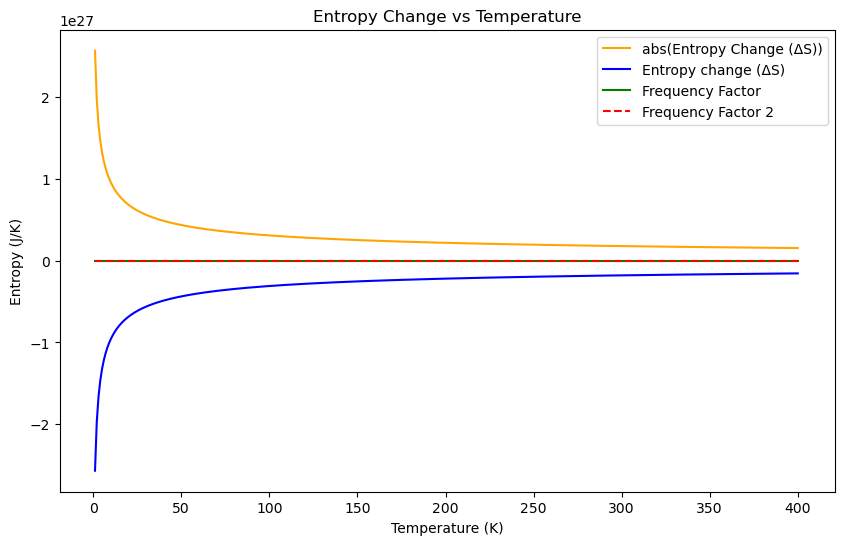

In [27]:
# Example values for a, b, c
a_value = 1     
b_value = 6.2e27    
c_value = 1e12    

# Add one more temperature value at the end
npoints = 400
temperature = np.linspace(1, npoints, npoints)
temperature = np.append(temperature, temperature[-1]+1)

# Calculate the entropy change
S_values = entropy(temperature, a_value, b_value, c_value)
deltaS1 = np.diff(S_values)
deltaS2 = S_values - S_values[0]

freq_factor1 = 2.53e+16 * np.exp(deltaS1 / KB)
freq_factor2 = 2.53e+16 * np.exp(deltaS2 / KB)

# Plot
plt.figure(figsize=(10, 6))
#plt.plot(temperature, S_values[:-1], label='Entropy (S)', color='blue')
plt.plot(temperature[:-1], abs(deltaS1), label='abs(Entropy Change (ΔS))', color='orange')
plt.plot(temperature[:-1], deltaS1, label='Entropy change (ΔS)', color='blue')
plt.plot(temperature[:-1], freq_factor1, label='Frequency Factor', color='green')
plt.plot(temperature, freq_factor2, label='Frequency Factor 2', color='red', linestyle='--')
plt.title('Entropy Change vs Temperature')
plt.xlabel('Temperature (K)')
plt.ylabel('Entropy (J/K)')
plt.legend()
plt.show()

In [28]:
## FREQ_FACTOR.PY
def entropy(temperature, a, b, c):
    """
    Calculates the entropy of a system given its temperature and parameters a, b, c.
    
    Parameters:
    temperature (float or array-like): Temperature in Kelvin
    a (float or array-like): Parameter a
    b (float or array-like): Parameter b
    c (float or array-like): Parameter c
    
    Returns:
    float or array-like: Entropy in J/K
    """
    kB = 8.6173335e-5           # Boltzmann constant (eV/K)
    
    first = c * np.log(1 + c * np.exp(-a/(kB * temperature)))
    second = 1/(kB * temperature) * a * c**2 * (np.exp(-a/(kB * temperature)) / (1 + c * np.exp(-a/(kB * temperature))))
    third = -1/(kB * temperature) * b * temperature**(3/2)
    return kB * (first + second + third)

def freq_factor(temperature, value):
    """
    Computes the frequency factor that follows the expression:
                 S = nu * K * exp(DeltaS / kB)
    
    * nu: lattice phonon vibration frequency (s-1)  
    * K: transition probability constant
    * kB: Boltzmann constant (eV/K)

    The entropy change (Delta S) is calculated using the entropy() function.
    
    Args:
        temperature: temperature range of the process (scalar or array)
    """
    kB = 8.6173335e-5           # Boltzmann constant (eV/K)
    K = 1                       # Transition probability constant (dimensionless)
    nu_m = 90000                # from B.H. Bransden book (m-1)
    nu_s = 2.53e+16             # (s-1)
    
    # Check if temperature is a scalar or array
    is_scalar = np.isscalar(temperature)
    
    if is_scalar:
        # If there is only one temperature value, create an array with two values
        temp_array = np.array([temperature, temperature + 1])
    else:
        # For array input, add one more temperature value at the end
        temp_array = np.append(temperature, temperature[-1]+1)
    
    # Calculate the entropy change
    S_values = entropy(temp_array, value.a, value.b, value.c)
    deltaS = np.diff(S_values)
    
    # Calculate frequency factor
    freq_factor_result = nu_s * K * np.exp(deltaS / kB)
    
    # Return scalar if input was scalar, otherwise return array
    if is_scalar:
        return freq_factor_result[0]
    else:
        return freq_factor_result


## DIFF_EQS_FREQFACTOR.PY
def diff_eqs_freqfactor(y0, t, value):
    """
    Defines the differential equations system to describe the change rate of electrons in the valence and conduction band of LiF:Mg,Ti. The equations considered are (3.3)-(3.6), which are:
    
        (3.3) dn_c/dt = G - sum_i dn_i/dt  +  (sum_R,NR A_mn_i * m_i) * n_c  
        (3.4) dn_i/dt = -p_i * n_i + A_i * (N_i - n_i) * n_c
        (3.5) dm_j/dt = -hp_j * m_j + A_j * (M_j - m_j) * n_v - jA_mn * m_j * n_c
        (3.6) dn_v/dt = G - sum_R,NR - p_h_i * m_i + A_h_i * (M_i - m_i) * n_c

    * G: electron-hole pairs generated by the radiation [cm-3 s-1]
    * n_c: electron density in the conduction band [cm-3]
    * n_v: electron density in the valence band [cm-3]
    * n_i: electron density in trap i [cm-3]
    * m_j : hole density in the recombination center j [cm-3]
    * N_i: total accesible positions for trap i [cm-3]
    * M_j : total density of ???
    * p_i: electron release probability factor for trap i [s-1]
    * hp_j : hole release probability factor for recombination center j [s-1]
    * A_i: electron trapping probability factor for trap i [cm3 s-1]
    * jA_mn: recombination probability factor for recombination center j [cm3 s-1]
    
    ### In this case, the frequency factor is defined with:
                s = nu * K * exp(Delta S / kB)
    
    Args:
        y0: initial condictions vector
        t: time vector
        value: parameters object
    """
    # Unpacking of variables
    n_I, n_II, n_III, n_IV, n_V, n_s, m_R, m_NR, n_c, n_v = y0
    
    # Definition of temperature change with the heating rate [K]
    temp_heating = 273.15 + value.T_C + value.hr * t
    
    # Computation of electron release probabilities
    p_I = freq_factor(temp_heating, value) * np.exp(-value.E_I / (value.kB * temp_heating))
    p_II = freq_factor(temp_heating, value) * np.exp(-value.E_II / (value.kB * temp_heating))
    p_III = freq_factor(temp_heating, value) * np.exp(-value.E_III / (value.kB * temp_heating))
    p_IV = freq_factor(temp_heating, value) * np.exp(-value.E_IV / (value.kB * temp_heating))
    p_V = freq_factor(temp_heating, value) * np.exp(-value.E_V / (value.kB * temp_heating))
    p_s = freq_factor(temp_heating, value) * np.exp(-value.E_s / (value.kB * temp_heating))
    
    p_R_h = freq_factor(temp_heating, value) * np.exp(-value.E_R_h / (value.kB * temp_heating))
    p_NR_h = freq_factor(temp_heating, value) * np.exp(-value.E_NR_h / (value.kB * temp_heating))
 
    # Equations (3.4) and (3.5) for each trap/recombination center
    dn_Idt = - p_I * n_I + value.A_I * (value.N_I - n_I) * n_c
    dn_IIdt = - p_II * n_II + value.A_II * (value.N_II - n_II) * n_c
    dn_IIIdt = - p_III * n_III + value.A_III * (value.N_III - n_III) * n_c
    dn_IVdt = - p_IV * n_IV + value.A_IV * (value.N_IV - n_IV) * n_c
    dn_Vdt = - p_V * n_V + value.A_V * (value.N_V - n_V) * n_c
    dn_sdt = - p_s * n_s + value.A_s * (value.N_s - n_s) * n_c
    
    dm_Rdt = - m_R * value.A_mn_R * n_c + value.A_R * (value.M_R - m_R) * n_v - p_R_h * m_R
    dm_NRdt = - m_NR * value.A_mn_NR * n_c + value.A_NR * (value.M_NR - m_NR) * n_v - p_NR_h * m_NR
    
    # Equations (3.3) and (3.6)
    dn_cdt = value.G - (dn_Idt + dn_IIdt + dn_IIIdt + dn_IVdt + dn_Vdt + dn_sdt) - value.A_mn_R * m_R * n_c - value.A_mn_NR * m_NR * n_c
    dn_vdt = value.G + (p_R_h * m_R + p_NR_h * m_NR) - (value.A_R * (value.M_R - m_R) + value.A_NR * (value.M_NR - m_NR)) * n_v

    return dn_Idt, dn_IIdt, dn_IIIdt, dn_IVdt, dn_Vdt, dn_sdt, dm_Rdt, dm_NRdt, dn_cdt, dn_vdt

In [29]:
# For the global variables, we need to define a SimpleNamespace
value = SimpleNamespace(
    a = a_value, b = b_value, c = c_value,
    kB=0,
    G=0, hr=0, 
    N_I=N_I, N_II=N_II, N_III=N_III, N_IV=N_IV, N_V=N_V, N_s=N_s,
    M_R=M_R, M_NR=M_NR,
    A_I=A_I, A_II=A_II, A_III=A_III, A_IV=A_IV, A_V=A_V, A_s=A_s, A_NR=A_NR, A_R=A_R,
    E_I=E_I, E_II=E_II, E_III=E_III, E_IV=E_IV, E_V=E_V, E_s=E_s, E_R_h=E_R_h, E_NR_h=E_NR_h,
    S_I=S_I, S_II=S_II, S_III=S_III, S_IV=S_IV, S_V=S_V, S_s=S_s, S_R_h=S_R_h, S_NR_h=S_NR_h,
    A_mn_NR=A_mn_NR, A_mn_R=A_mn_R
)
# Define the columns for the dataframe
column_names = [
    'n_I', 'n_II', 'n_III', 'n_IV', 'n_V',
    'n_s', 'm_R', 'm_NR', 'n_c', 'n_v',
    'dm_R', 'dm_NR'
]

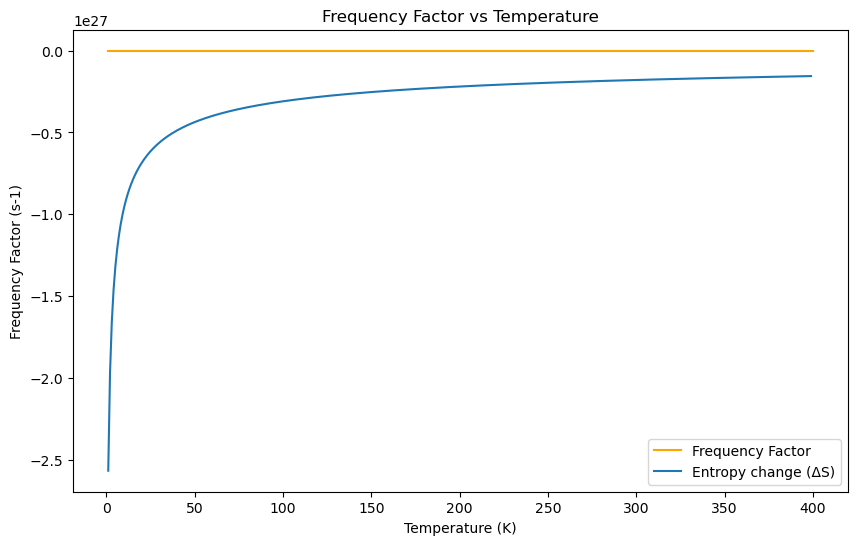

In [30]:
## Frequency factor used in the simulations
# !!!!!!!!!!!!!! Aquí está el problema

temperature = np.linspace(1, 400, 400)  # Temperature range from 1 to 400 K

freq_factors = freq_factor(temperature, value)
deltaS = np.diff(entropy(temperature, value.a, value.b, value.c))

plt.figure(figsize=(10, 6))
plt.plot(temperature, freq_factors, label='Frequency Factor', color='orange')
plt.plot(temperature[:-1], deltaS, label='Entropy change (ΔS)')
plt.title('Frequency Factor vs Temperature')
plt.xlabel('Temperature (K)')
plt.ylabel('Frequency Factor (s-1)')
plt.legend()
plt.show()


## 4. First TL glow curve simulation

/Users/martadelarosanunez/Library/CloudStorage/OneDrive-Personal/Universidad/Code/GitHub/Temp_dependent_freqfactor/src/plotting.py:48: RuntimeWarning: invalid value encountered in divide
  plt.plot(x_axis, (n_c + n_I + n_II + n_III + n_IV + n_V + n_s)/(m_R + m_NR + n_v))


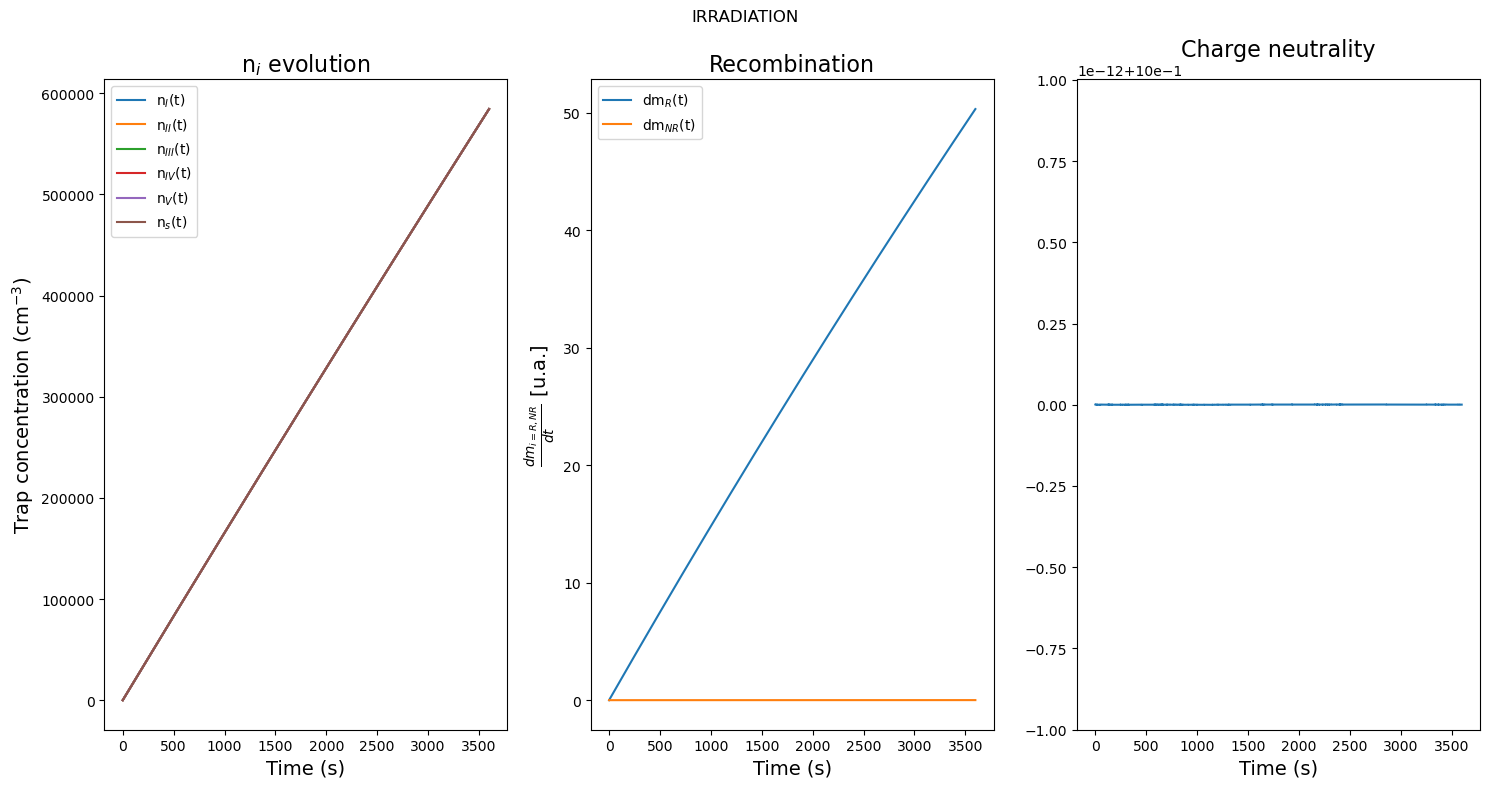

In [31]:
#-------------------------------------------------------------------------
## IRRADIATION
# Parameters for IRRADIATION
value.kB = 8.617e-5        # Boltzmann constant (eV/K)
value.T_C = 25             # Temperature (ºC)
value.hr = 0               # Heating rate (ºC/s)
value.G = 1000             # Electron-hole pair generation (cm-3 s-1)

# Time vector (s)
npoints = 3600
t = np.linspace(0, npoints-1, npoints)

# Initial conditions vector (order: n_I, n_II, n_III, n_IV, n_V, n_s, m_R, m_NR, n_c, n_v)
n_I_0, n_II_0, n_III_0, n_IV_0, n_V_0, n_s_0, m_R_0, m_NR_0, n_c_0, n_v_0 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
y0 = [n_I_0, n_II_0, n_III_0, n_IV_0, n_V_0, n_s_0, m_R_0, m_NR_0, n_c_0, n_v_0]

# Solving the differential equations system for TEMPERATURE DEPENDENCY
irradiation = odeint(diff_eqs_freqfactor, y0, t, args=(value,))
n_I, n_II, n_III ,n_IV ,n_V ,n_s ,m_R ,m_NR ,n_c , n_v = irradiation.T

# Plotting the results
plot_results(irradiation, 'Results/', 'IRRADIATION', t, value)

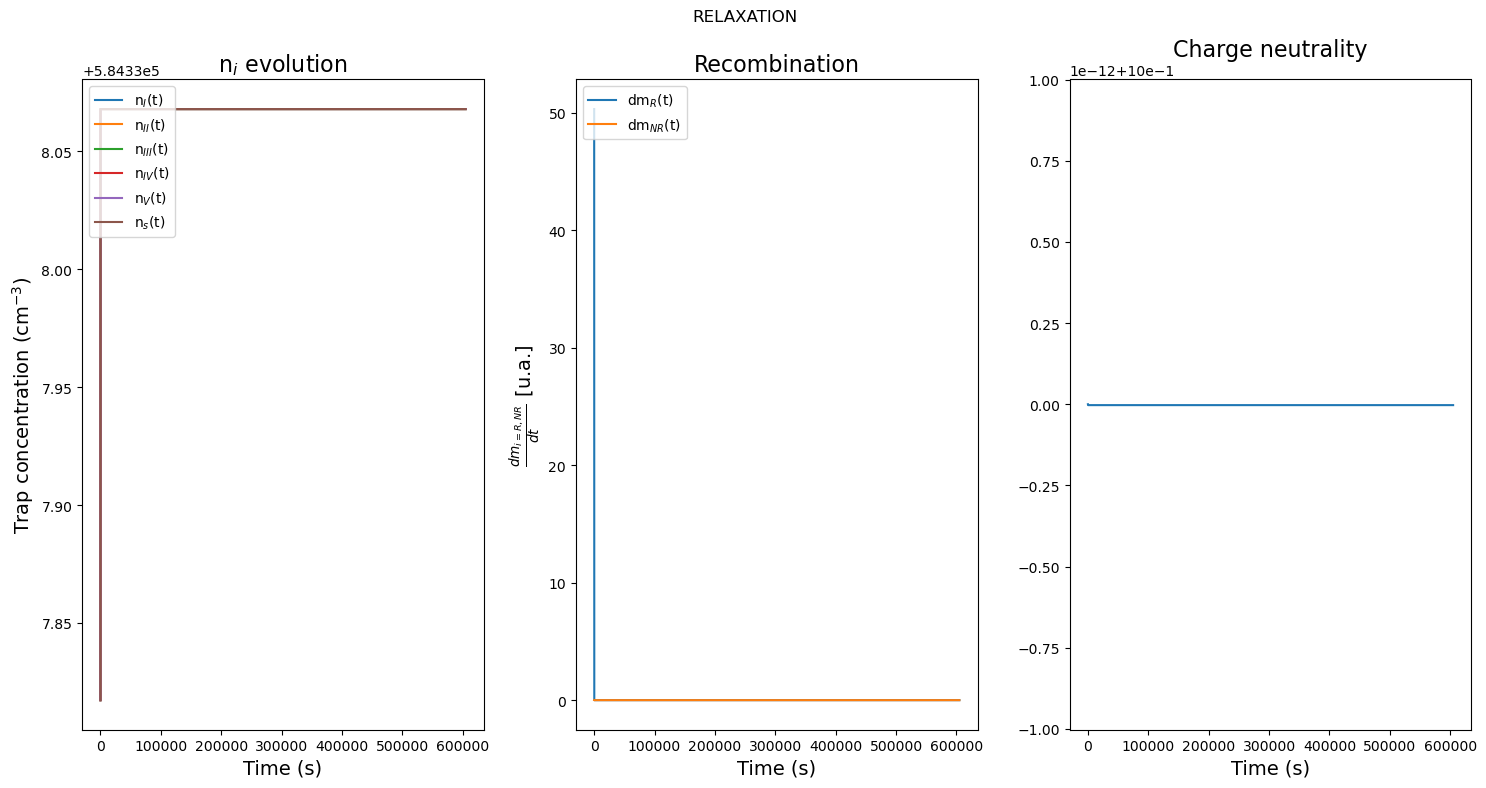

In [32]:
#-------------------------------------------------------------------------
## 2.2 RELAXATION
# Parameters for RELAXATION
value.T_C = 25             # Temperature (ºC)
value.hr = 0               # Heating rate (ºC/s)
value.G = 0                # Electron-hole pair generation (cm-3 s-1)

# Time vector (s)
npoints = 3600 * 24 * 7
t = np.linspace(0, npoints-1, npoints)

# Initial conditions vector
n_I_0,n_II_0,n_III_0,n_IV_0,n_V_0,n_s_0,m_NR_0,m_R_0,n_c_0,n_v_0=n_I[-1],n_II[-1],n_III[-1],n_IV[-1],n_V[-1],n_s[-1],m_R[-1],m_NR[-1],n_c[-1], n_v[-1]
y0 = [n_I_0,n_II_0,n_III_0,n_IV_0,n_V_0,n_s_0,m_NR_0,m_R_0,n_c_0,n_v_0]

# Solving the differential equations system
relaxation = odeint(diff_eqs_freqfactor, y0, t, args=(value,))
n_I, n_II, n_III ,n_IV ,n_V ,n_s ,m_R ,m_NR ,n_c , n_v = relaxation.T

# Plotting the results
plot_results(relaxation, 'Results/', 'RELAXATION', t, value)

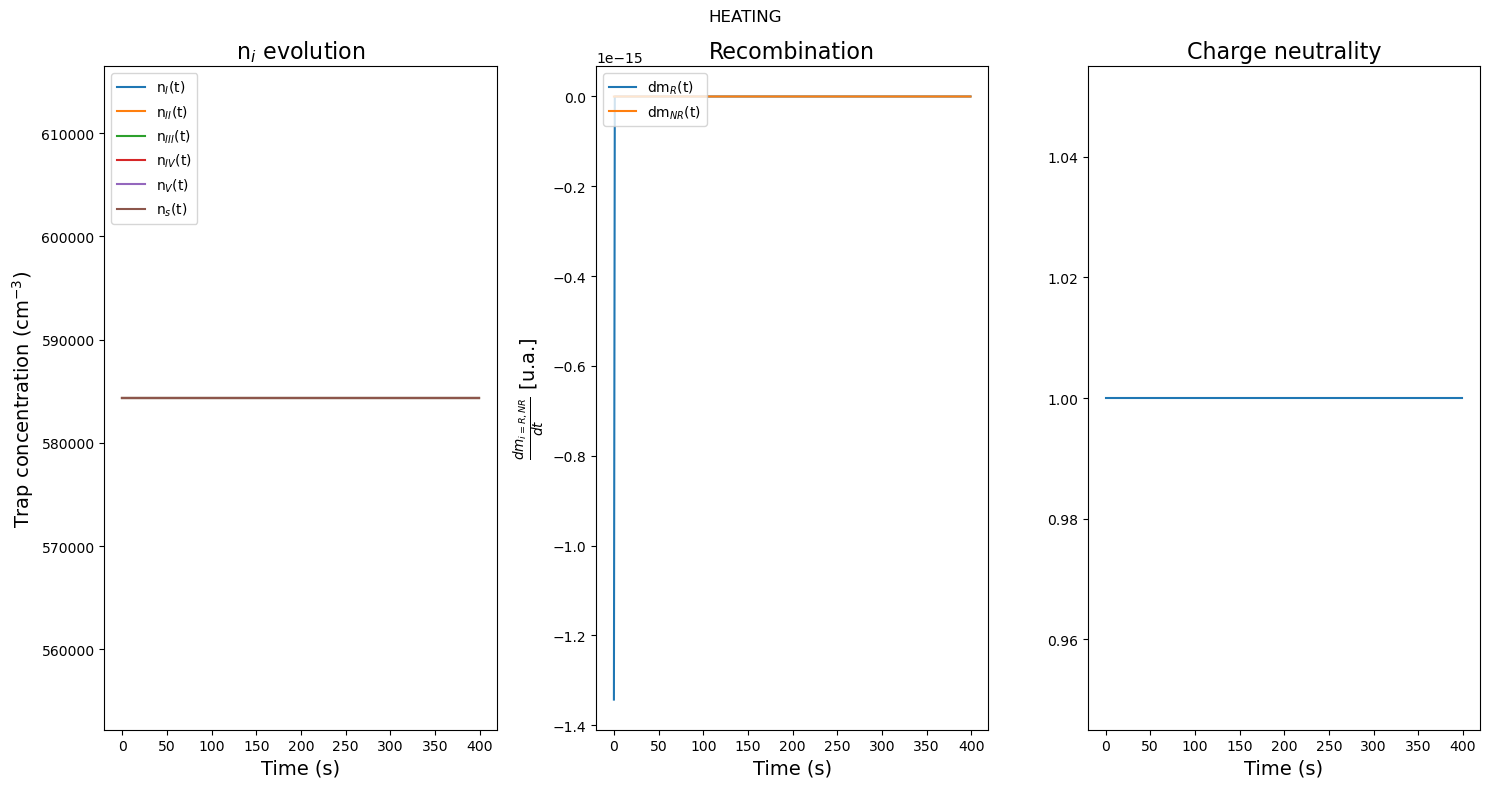

In [33]:
#-------------------------------------------------------------------------
## 2.3 HEATING
# Parameters for HEATING
value.T_C = 0             # Temperature (ºC)
value.hr = 1.0             # Heating rate (ºC/s)
value.G = 0                # Electron-hole pair generation (cm-3 s-1)

# Time vector (s)
npoints = 400
t = np.linspace(0, npoints-1, npoints)

# Initial conditions vector
n_I_0,n_II_0,n_III_0,n_IV_0,n_V_0,n_s_0,m_NR_0,m_R_0,n_c_0,n_v_0=n_I[1],n_II[1],n_III[1],n_IV[1],n_V[1],n_s[1],m_R[1],m_NR[1],n_c[1], n_v[1]
y0 = [n_I_0,n_II_0,n_III_0,n_IV_0,n_V_0,n_s_0,m_NR_0,m_R_0,n_c_0,n_v_0]

# Solving the differential equations system
heating = odeint(diff_eqs_freqfactor, y0, t, args=(value,))
n_I, n_II, n_III ,n_IV ,n_V ,n_s ,m_R ,m_NR ,n_c , n_v = heating.T

# Plotting the results
temp_plot = value.T_C + value.hr * t
dm_R = m_R * value.A_mn_R * n_c
dm_NR = m_NR * value.A_mn_NR * n_c
plot_results(heating, 'Results/', 'HEATING', temp_plot, value)

## 5. Training the model

- Give the parameters an initial value
- Create an error function that compares the model with the data for the given a, b and c parameters
- Use a minimization algorithm to find the best parameters that minimize the error function

Current error with a=0.39412, b=7.73336e+29, c=613598600000000.0: 3.64e+09
Simple error between current experimental and simulated data: 3.64e+09


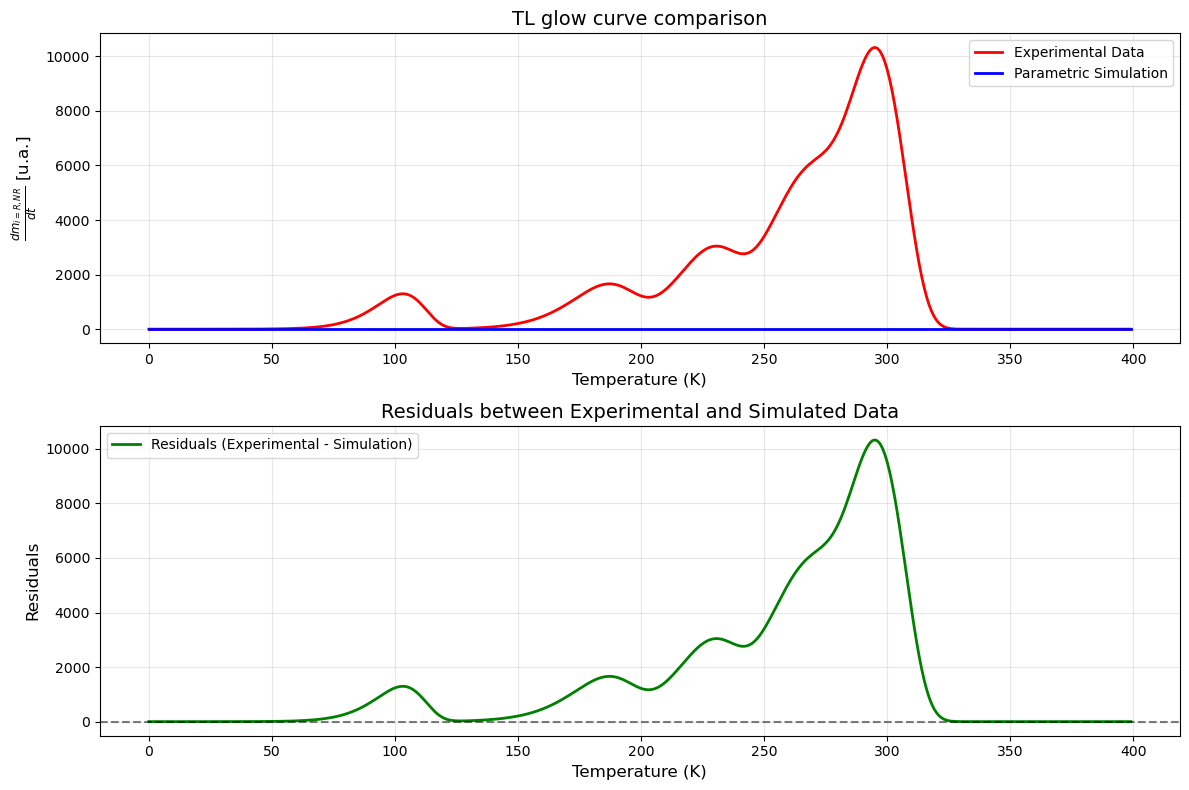

In [34]:
## ERROR FUNCTION FOR PARAMETER OPTIMIZATION

def objective_function(params, exp_intensity, exp_time):
    """
    Objective function for optimizing parameters a, b, c.
    This function runs the complete simulation with given parameters and returns the total error.
    
    Args:
        params (list): [a, b, c] parameters to optimize
        exp_intensity (array): Experimental TL intensity data
        exp_time (array): Experimental time data
    
    Returns:
        float: Total sum of squared errors between experimental and simulated data
    """
    try:
        # Extract parameters
        a_val, b_val, c_val = params
        
        # Create a new value object with the trial parameters
        trial_value = SimpleNamespace(
            a=a_val, b=b_val, c=c_val,
            kB=8.617e-5,
            G=0, hr=0, T_C=25,
            N_I=N_I, N_II=N_II, N_III=N_III, N_IV=N_IV, N_V=N_V, N_s=N_s,
            M_R=M_R, M_NR=M_NR,
            A_I=A_I, A_II=A_II, A_III=A_III, A_IV=A_IV, A_V=A_V, A_s=A_s, A_NR=A_NR, A_R=A_R,
            E_I=E_I, E_II=E_II, E_III=E_III, E_IV=E_IV, E_V=E_V, E_s=E_s, E_R_h=E_R_h, E_NR_h=E_NR_h,
            S_I=S_I, S_II=S_II, S_III=S_III, S_IV=S_IV, S_V=S_V, S_s=S_s, S_R_h=S_R_h, S_NR_h=S_NR_h,
            A_mn_NR=A_mn_NR, A_mn_R=A_mn_R
        )
        
        # Run IRRADIATION phase
        trial_value.T_C = 25
        trial_value.hr = 0
        trial_value.G = 1000
        
        npoints = 3600
        t = np.linspace(0, npoints-1, npoints)
        y0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # Initial conditions
        
        irradiation = odeint(diff_eqs_freqfactor, y0, t, args=(trial_value,))
        n_I, n_II, n_III, n_IV, n_V, n_s, m_R, m_NR, n_c, n_v = irradiation.T
        
        # Run RELAXATION phase
        trial_value.T_C = 25
        trial_value.hr = 0
        trial_value.G = 0
        
        npoints_relax = 3600 * 24 * 7
        t_relax = np.linspace(0, npoints_relax-1, npoints_relax)
        y0_relax = [n_I[-1], n_II[-1], n_III[-1], n_IV[-1], n_V[-1], n_s[-1], m_R[-1], m_NR[-1], n_c[-1], n_v[-1]]
        
        relaxation = odeint(diff_eqs_freqfactor, y0_relax, t_relax, args=(trial_value,))
        n_I, n_II, n_III, n_IV, n_V, n_s, m_R, m_NR, n_c, n_v = relaxation.T
        
        # Run HEATING phase (this generates the TL curve)
        trial_value.T_C = 0
        trial_value.hr = 1.0
        trial_value.G = 0
        
        npoints_heat = 400
        t_heat = np.linspace(0, npoints_heat-1, npoints_heat)
        y0_heat = [n_I[1], n_II[1], n_III[1], n_IV[1], n_V[1], n_s[1], m_R[1], m_NR[1], n_c[1], n_v[1]]
        
        heating = odeint(diff_eqs_freqfactor, y0_heat, t_heat, args=(trial_value,))
        n_I_h, n_II_h, n_III_h, n_IV_h, n_V_h, n_s_h, m_R_h, m_NR_h, n_c_h, n_v_h = heating.T
        
        # Calculate simulated TL intensity
        sim_intensity = m_R_h * trial_value.A_mn_R * n_c_h
        
        # Calculate error (sum of squared differences)
        error = np.sum((exp_intensity - sim_intensity)**2)
        
        return error
    
    except Exception as e:
        # Return a large error if simulation fails
        print(f"Simulation failed with parameters {params}: {e}")
        return 1e10

def simple_error_function(exp_intensity, sim_intensity):
    """
    Simple error function for comparing two curves.
    
    Args:
        exp_intensity (array): Experimental data
        sim_intensity (array): Simulated data
    
    Returns:
        float: Sum of squared errors
    """
    return np.sum((exp_intensity - sim_intensity)**2)

# Test the objective function with current parameters
current_params = [value.a, value.b, value.c]
current_params = [0.394120, 7.733360e+29, 6.135986e+14]                # After PSO
current_error = objective_function(current_params, exp_intensity, exp_time)
print(f"Current error with a={current_params[0]}, b={current_params[1]}, c={current_params[2]}: {current_error:.2e}")

# Calculate the error function for the current simulation results
simple_error = simple_error_function(exp_intensity, dm_R)
print(f"Simple error between current experimental and simulated data: {simple_error:.2e}")

# Plot both TL curves and the error function
plt.figure(figsize=(12, 8))

# Subplot 1: TL curves comparison
plt.subplot(2, 1, 1)
plt.plot(temp_plot, exp_intensity, label='Experimental Data', color='red', linewidth=2)
plt.plot(temp_plot, dm_R, label='Parametric Simulation', color='blue', linewidth=2)
plt.xlabel('Temperature (K)', fontsize=12)
plt.ylabel(r'$\frac{dm_{i=R,NR}}{dt}$ [u.a.]', fontsize=12)
plt.title('TL glow curve comparison', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Error (residuals)
plt.subplot(2, 1, 2)
residuals = exp_intensity - dm_R
plt.plot(temp_plot, residuals, label='Residuals (Experimental - Simulation)', color='green', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Temperature (K)', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residuals between Experimental and Simulated Data', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [35]:
## PARAMETER OPTIMIZATION USING DIFFERENT ALGORITHMS

# Import optimization libraries
from scipy.optimize import minimize, differential_evolution
from scipy.optimize import basinhopping

print("Setting up optimization algorithms...")

# Define parameter bounds (adjust these based on physical constraints)
# Format: [(min_a, max_a), (min_b, max_b), (min_c, max_c)]
bounds = [
    (0.1, 20),        # bounds for parameter 'a'
    (1e1, 1e30),     # bounds for parameter 'b' 
    (1e1, 1e30)      # bounds for parameter 'c'
]

# Initial guess (starting point for optimization)
initial_guess = [1.0, 6.2e27, 1e12]

print(f"Initial parameters: a={initial_guess[0]}, b={initial_guess[1]:.2e}, c={initial_guess[2]:.2e}")
print(f"Initial error: {objective_function(initial_guess, exp_intensity, exp_time):.2e}")
print()

# Method 1: Scipy minimize with Nelder-Mead (doesn't require gradients)
print("=" * 60)
print("Method 1: Nelder-Mead Optimization")
print("=" * 60)

try:
    result_nm = minimize(
        objective_function, 
        initial_guess, 
        args=(exp_intensity, exp_time),
        method='Nelder-Mead',
        options={'maxiter': 100, 'disp': True}
    )
    
    print(f"Optimization successful: {result_nm.success}")
    print(f"Optimized parameters: a={result_nm.x[0]:.3f}, b={result_nm.x[1]:.2e}, c={result_nm.x[2]:.2e}")
    print(f"Final error: {result_nm.fun:.2e}")
    print(f"Function evaluations: {result_nm.nfev}")
except Exception as e:
    print(f"Nelder-Mead optimization failed: {e}")

print("\n" + "=" * 60)
print("Method 2: Differential Evolution (Global Optimization)")
print("=" * 60)

# Method 2: Differential Evolution (global optimization, good for complex landscapes)
try:
    result_de = differential_evolution(
        objective_function,
        bounds,
        args=(exp_intensity, exp_time),
        maxiter=50,  # Reduced for demonstration
        popsize=10,  # Reduced for demonstration
        seed=42,
        disp=True
    )
    
    print(f"Optimization successful: {result_de.success}")
    print(f"Optimized parameters: a={result_de.x[0]:.3f}, b={result_de.x[1]:.2e}, c={result_de.x[2]:.2e}")
    print(f"Final error: {result_de.fun:.2e}")
    print(f"Function evaluations: {result_de.nfev}")
except Exception as e:
    print(f"Differential Evolution optimization failed: {e}")

print("\n" + "=" * 60)
print("Method 3: Basin Hopping (Global + Local)")
print("=" * 60)

# Method 3: Basin Hopping (combines global and local search)
try:
    minimizer_kwargs = {"method": "L-BFGS-B", "bounds": bounds, "args": (exp_intensity, exp_time)}
    
    result_bh = basinhopping(
        objective_function,
        initial_guess,
        minimizer_kwargs=minimizer_kwargs,
        niter=20,  # Reduced for demonstration
        disp=True
    )
    
    print(f"Optimization successful: {result_bh.lowest_optimization_result.success}")
    print(f"Optimized parameters: a={result_bh.x[0]:.3f}, b={result_bh.x[1]:.2e}, c={result_bh.x[2]:.2e}")
    print(f"Final error: {result_bh.fun:.2e}")
    print(f"Function evaluations: {result_bh.nfev}")
except Exception as e:
    print(f"Basin Hopping optimization failed: {e}")

print("\n" + "=" * 60)
print("Summary")
print("=" * 60)
print("Initial error:      {:.2e}".format(objective_function(initial_guess, exp_intensity, exp_time)))

# Compare results if available
try:
    if 'result_nm' in locals() and result_nm.success:
        print("Nelder-Mead error:  {:.2e}".format(result_nm.fun))
except:
    pass

try:
    if 'result_de' in locals() and result_de.success:
        print("Diff. Evolution:    {:.2e}".format(result_de.fun))
except:
    pass

try:
    if 'result_bh' in locals() and result_bh.lowest_optimization_result.success:
        print("Basin Hopping:      {:.2e}".format(result_bh.fun))
except:
    pass

Setting up optimization algorithms...
Initial parameters: a=1.0, b=6.20e+27, c=1.00e+12
Initial error: 3.64e+09

Method 1: Nelder-Mead Optimization


/var/folders/_c/s9xtx7kn61l5wvpw4pyjsc8c0000gn/T/ipykernel_15940/4072461095.py:30: RuntimeWarning: Maximum number of iterations has been exceeded.
  result_nm = minimize(


Optimization successful: False
Optimized parameters: a=1.000, b=6.20e+27, c=1.00e+12
Final error: 3.64e+09
Function evaluations: 499

Method 2: Differential Evolution (Global Optimization)
differential_evolution step 1: f(x)= 3642509249.5244117
Polishing solution with 'L-BFGS-B'
Optimization successful: True
Optimized parameters: a=3.280, b=6.08e+29, c=6.91e+29
Final error: 3.64e+09
Function evaluations: 64

Method 3: Basin Hopping (Global + Local)
basinhopping step 0: f 3.64251e+09
basinhopping step 1: f 3.64251e+09 trial_f 3.64251e+09 accepted 1  lowest_f 3.64251e+09
basinhopping step 2: f 3.64251e+09 trial_f 3.64251e+09 accepted 1  lowest_f 3.64251e+09
basinhopping step 3: f 3.64251e+09 trial_f 3.64251e+09 accepted 1  lowest_f 3.64251e+09
basinhopping step 4: f 3.64251e+09 trial_f 3.64251e+09 accepted 1  lowest_f 3.64251e+09
basinhopping step 5: f 3.64251e+09 trial_f 3.64251e+09 accepted 1  lowest_f 3.64251e+09
basinhopping step 6: f 3.64251e+09 trial_f 3.64251e+09 accepted 1  lowes

PARTICLE SWARM OPTIMIZATION
Starting Particle Swarm Optimization...
Particles: 15, Max iterations: 30
Parameters: w=0.7, c1=1.5, c2=1.5
------------------------------------------------------------
Iteration   0: Best fitness = 3.64e+09
               Best params: a=2.969, b=1.61e+29, c=9.30e+14
Iteration  10: Best fitness = 3.64e+09
               Best params: a=2.969, b=1.61e+29, c=9.30e+14
Iteration  20: Best fitness = 3.64e+09
               Best params: a=2.969, b=1.61e+29, c=9.30e+14
Iteration  29: Best fitness = 3.64e+09
               Best params: a=2.969, b=1.61e+29, c=9.30e+14

PSO RESULTS
Best parameters found:
  a = 2.968539
  b = 1.612297e+29
  c = 9.296984e+14
Best fitness (error): 3.642509e+09


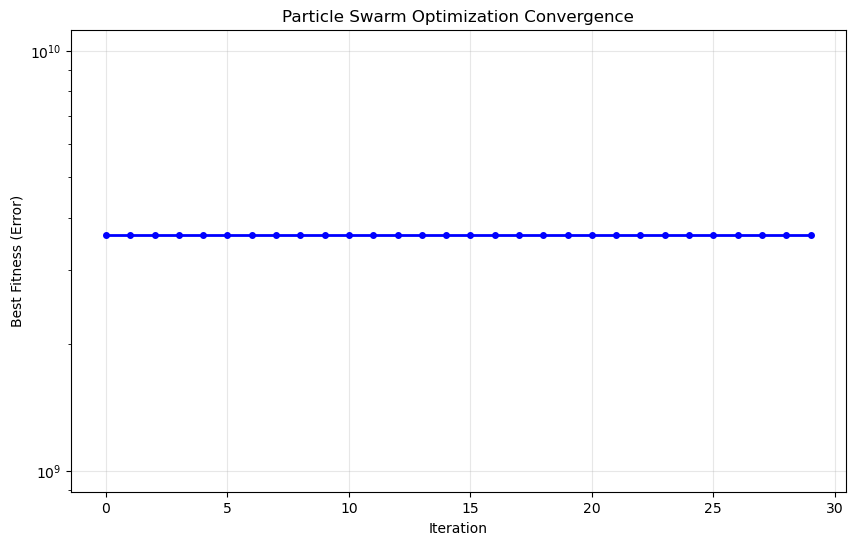


COMPARISON: INITIAL vs OPTIMIZED PARAMETERS
Initial:   a=1.000, b=6.20e+27, c=1.00e+12
Optimized: a=2.969, b=1.61e+29, c=9.30e+14
Initial error:   3.64e+09
Optimized error: 3.64e+09
Improvement: 0.0%


In [36]:
## PARTICLE SWARM OPTIMIZATION (PSO) IMPLEMENTATION

def particle_swarm_optimization(objective_func, bounds, args=(), n_particles=20, max_iter=50, 
                               w=0.7, c1=1.5, c2=1.5, verbose=True):
    """
    Particle Swarm Optimization implementation for parameter optimization.
    
    Args:
        objective_func: Function to minimize
        bounds: List of (min, max) tuples for each parameter
        args: Additional arguments for objective function
        n_particles: Number of particles in the swarm
        max_iter: Maximum number of iterations
        w: Inertia weight
        c1: Cognitive parameter
        c2: Social parameter
        verbose: Print progress
    
    Returns:
        best_position: Best parameters found
        best_fitness: Best fitness (error) value
        fitness_history: History of best fitness values
    """
    
    # Initialize parameters
    n_dims = len(bounds)
    
    # Initialize particle positions and velocities
    positions = np.random.uniform(
        low=[b[0] for b in bounds], 
        high=[b[1] for b in bounds], 
        size=(n_particles, n_dims)
    )
    
    velocities = np.random.uniform(
        low=-1, high=1, size=(n_particles, n_dims)
    )
    
    # Initialize personal best positions and fitness
    personal_best_positions = positions.copy()
    personal_best_fitness = np.full(n_particles, np.inf)
    
    # Initialize global best
    global_best_position = None
    global_best_fitness = np.inf
    
    # Fitness history for plotting
    fitness_history = []
    
    if verbose:
        print("Starting Particle Swarm Optimization...")
        print(f"Particles: {n_particles}, Max iterations: {max_iter}")
        print(f"Parameters: w={w}, c1={c1}, c2={c2}")
        print("-" * 60)
    
    # Main PSO loop
    for iteration in range(max_iter):
        
        # Evaluate fitness for each particle
        for i in range(n_particles):
            try:
                # Ensure particles stay within bounds
                positions[i] = np.clip(positions[i], 
                                     [b[0] for b in bounds], 
                                     [b[1] for b in bounds])
                
                # Calculate fitness
                fitness = objective_func(positions[i], *args)
                
                # Update personal best
                if fitness < personal_best_fitness[i]:
                    personal_best_fitness[i] = fitness
                    personal_best_positions[i] = positions[i].copy()
                
                # Update global best
                if fitness < global_best_fitness:
                    global_best_fitness = fitness
                    global_best_position = positions[i].copy()
                    
            except Exception as e:
                # If evaluation fails, assign large fitness
                fitness = 1e10
                if verbose and iteration == 0:
                    print(f"Particle {i} evaluation failed: {e}")
        
        # Store best fitness for this iteration
        fitness_history.append(global_best_fitness)
        
        if verbose and (iteration % 10 == 0 or iteration == max_iter - 1):
            print(f"Iteration {iteration:3d}: Best fitness = {global_best_fitness:.2e}")
            if global_best_position is not None:
                print(f"               Best params: a={global_best_position[0]:.3f}, "
                      f"b={global_best_position[1]:.2e}, c={global_best_position[2]:.2e}")
        
        # Update velocities and positions
        for i in range(n_particles):
            # Random factors
            r1, r2 = np.random.random(n_dims), np.random.random(n_dims)
            
            # Update velocity
            cognitive = c1 * r1 * (personal_best_positions[i] - positions[i])
            social = c2 * r2 * (global_best_position - positions[i]) if global_best_position is not None else 0
            
            velocities[i] = w * velocities[i] + cognitive + social
            
            # Update position
            positions[i] += velocities[i]
    
    return global_best_position, global_best_fitness, fitness_history

# Run Particle Swarm Optimization
print("=" * 60)
print("PARTICLE SWARM OPTIMIZATION")
print("=" * 60)

# PSO parameters
pso_bounds = [
    (0.1, 10),        # bounds for parameter 'a'
    (1e25, 1e30),     # bounds for parameter 'b' 
    (1e10, 1e15)      # bounds for parameter 'c'
]

try:
    best_params, best_fitness, pso_history = particle_swarm_optimization(
        objective_function,
        pso_bounds,
        args=(exp_intensity, exp_time),
        n_particles=15,  # Reduced for demonstration
        max_iter=30,     # Reduced for demonstration
        w=0.7,
        c1=1.5,
        c2=1.5,
        verbose=True
    )
    
    print("\n" + "=" * 60)
    print("PSO RESULTS")
    print("=" * 60)
    print(f"Best parameters found:")
    print(f"  a = {best_params[0]:.6f}")
    print(f"  b = {best_params[1]:.6e}")
    print(f"  c = {best_params[2]:.6e}")
    print(f"Best fitness (error): {best_fitness:.6e}")
    
    # Plot convergence
    plt.figure(figsize=(10, 6))
    plt.plot(pso_history, 'b-', linewidth=2, marker='o', markersize=4)
    plt.xlabel('Iteration')
    plt.ylabel('Best Fitness (Error)')
    plt.title('Particle Swarm Optimization Convergence')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better visualization
    plt.show()
    
except Exception as e:
    print(f"PSO failed: {e}")

# Compare initial vs optimized (if PSO succeeded)
try:
    if 'best_params' in locals():
        print("\n" + "=" * 60)
        print("COMPARISON: INITIAL vs OPTIMIZED PARAMETERS")
        print("=" * 60)
        print(f"Initial:   a={initial_guess[0]:.3f}, b={initial_guess[1]:.2e}, c={initial_guess[2]:.2e}")
        print(f"Optimized: a={best_params[0]:.3f}, b={best_params[1]:.2e}, c={best_params[2]:.2e}")
        print(f"Initial error:   {objective_function(initial_guess, exp_intensity, exp_time):.2e}")
        print(f"Optimized error: {best_fitness:.2e}")
        improvement = (objective_function(initial_guess, exp_intensity, exp_time) - best_fitness) / objective_function(initial_guess, exp_intensity, exp_time) * 100
        print(f"Improvement: {improvement:.1f}%")
except:
    pass

In [37]:
## OPTIMIZATION DIAGNOSTICS - WHY ISN'T THE ERROR CHANGING?

print("=" * 70)
print("OPTIMIZATION DIAGNOSTICS")
print("=" * 70)

# Test 1: Check if objective function is working correctly
print("\n1. TESTING OBJECTIVE FUNCTION SENSITIVITY")
print("-" * 50)

# Current parameters
current_params = [1.0, 6.2e27, 1e12]
current_error = objective_function(current_params, exp_intensity, exp_time)
print(f"Current error: {current_error:.2e}")

# Test small variations around current parameters
variations = [
    [1.1, 6.2e27, 1e12],      # Change a by 10%
    [0.9, 6.2e27, 1e12],      # Change a by -10%
    [1.0, 6.8e27, 1e12],      # Change b by 10%
    [1.0, 5.6e27, 1e12],      # Change b by -10%
    [1.0, 6.2e27, 1.1e12],    # Change c by 10%
    [1.0, 6.2e27, 0.9e12],    # Change c by -10%
]

print("\nTesting small parameter variations:")
for i, params in enumerate(variations):
    try:
        error = objective_function(params, exp_intensity, exp_time)
        change = (error - current_error) / current_error * 100
        print(f"Variation {i+1}: a={params[0]:.3f}, b={params[1]:.2e}, c={params[2]:.2e}")
        print(f"   Error: {error:.2e} (Change: {change:+.2f}%)")
    except Exception as e:
        print(f"Variation {i+1}: FAILED - {e}")

# Test 2: Check parameter bounds coverage
print("\n\n2. TESTING PARAMETER BOUNDS")
print("-" * 50)

# Test extreme values within bounds
extreme_tests = [
    [0.1, 1e25, 1e10],    # Lower bounds
    [10, 1e30, 1e15],     # Upper bounds
    [5, 5e27, 5e12],      # Middle values
]

print("Testing extreme parameter values:")
for i, params in enumerate(extreme_tests):
    try:
        error = objective_function(params, exp_intensity, exp_time)
        print(f"Test {i+1}: a={params[0]:.3f}, b={params[1]:.2e}, c={params[2]:.2e}")
        print(f"   Error: {error:.2e}")
    except Exception as e:
        print(f"Test {i+1}: FAILED - {e}")

# Test 3: Random sampling to understand the landscape
print("\n\n3. RANDOM SAMPLING OF PARAMETER SPACE")
print("-" * 50)

np.random.seed(42)  # For reproducibility
n_samples = 10
errors = []
params_tested = []

print("Testing random parameter combinations:")
for i in range(n_samples):
    # Random parameters within bounds
    a_rand = np.random.uniform(0.1, 10)
    b_rand = np.random.uniform(1e25, 1e30)
    c_rand = np.random.uniform(1e10, 1e15)
    params = [a_rand, b_rand, c_rand]
    
    try:
        error = objective_function(params, exp_intensity, exp_time)
        errors.append(error)
        params_tested.append(params)
        print(f"Sample {i+1}: a={params[0]:.3f}, b={params[1]:.2e}, c={params[2]:.2e}")
        print(f"   Error: {error:.2e}")
    except Exception as e:
        print(f"Sample {i+1}: FAILED - {e}")

# Analysis of random sampling
if errors:
    min_error = min(errors)
    max_error = max(errors)
    avg_error = np.mean(errors)
    std_error = np.std(errors)
    
    print(f"\nRandom sampling statistics:")
    print(f"  Min error: {min_error:.2e}")
    print(f"  Max error: {max_error:.2e}")
    print(f"  Avg error: {avg_error:.2e}")
    print(f"  Std error: {std_error:.2e}")
    print(f"  Error range: {max_error/min_error:.2f}x")
    
    if min_error < current_error:
        best_idx = np.argmin(errors)
        best_params = params_tested[best_idx]
        improvement = (current_error - min_error) / current_error * 100
        print(f"\n🎯 FOUND BETTER PARAMETERS!")
        print(f"  Best params: a={best_params[0]:.6f}, b={best_params[1]:.6e}, c={best_params[2]:.6e}")
        print(f"  Best error: {min_error:.2e}")
        print(f"  Improvement: {improvement:.1f}%")

# Test 4: Check if the issue is with simulation convergence
print("\n\n4. TESTING SIMULATION STABILITY")
print("-" * 50)

# Run the same parameters multiple times to check for randomness
test_params = [1.0, 6.2e27, 1e12]
repeated_errors = []

print("Testing simulation repeatability (same parameters, multiple runs):")
for i in range(3):
    try:
        error = objective_function(test_params, exp_intensity, exp_time)
        repeated_errors.append(error)
        print(f"Run {i+1}: {error:.2e}")
    except Exception as e:
        print(f"Run {i+1}: FAILED - {e}")

if len(repeated_errors) > 1:
    if max(repeated_errors) == min(repeated_errors):
        print("✅ Simulation is deterministic (good)")
    else:
        print("⚠️  Simulation has randomness - this could cause optimization issues")

# Test 5: Simplified objective function test
print("\n\n5. TESTING SIMPLIFIED OBJECTIVE FUNCTION")
print("-" * 50)

def simple_test_function(params):
    """Simple quadratic function to test if optimization algorithms work"""
    a, b, c = params
    # Simple quadratic with minimum at [2, 5e27, 3e12]
    return (a - 2)**2 + ((b - 5e27)/1e27)**2 + ((c - 3e12)/1e12)**2

print("Testing optimization on simple quadratic function...")
print("True minimum should be at: a=2, b=5e27, c=3e12")

# Test one optimization method on simple function
try:
    from scipy.optimize import minimize
    result = minimize(simple_test_function, [1.0, 6.2e27, 1e12], method='Nelder-Mead')
    print(f"Optimization result: a={result.x[0]:.3f}, b={result.x[1]:.2e}, c={result.x[2]:.2e}")
    print(f"Final value: {result.fun:.2e}")
    print(f"Success: {result.success}")
    
    if result.success and abs(result.x[0] - 2) < 0.1:
        print("✅ Optimization algorithms are working correctly")
    else:
        print("❌ There might be an issue with the optimization setup")
        
except Exception as e:
    print(f"Simple function test failed: {e}")

print("\n" + "=" * 70)
print("DIAGNOSIS COMPLETE")
print("=" * 70)

OPTIMIZATION DIAGNOSTICS

1. TESTING OBJECTIVE FUNCTION SENSITIVITY
--------------------------------------------------
Current error: 3.64e+09

Testing small parameter variations:
Variation 1: a=1.100, b=6.20e+27, c=1.00e+12
   Error: 3.64e+09 (Change: +0.00%)
Variation 2: a=0.900, b=6.20e+27, c=1.00e+12
   Error: 3.64e+09 (Change: +0.00%)
Variation 3: a=1.000, b=6.80e+27, c=1.00e+12
   Error: 3.64e+09 (Change: +0.00%)
Variation 4: a=1.000, b=5.60e+27, c=1.00e+12
   Error: 3.64e+09 (Change: +0.00%)
Variation 5: a=1.000, b=6.20e+27, c=1.10e+12
   Error: 3.64e+09 (Change: +0.00%)
Variation 6: a=1.000, b=6.20e+27, c=9.00e+11
   Error: 3.64e+09 (Change: +0.00%)


2. TESTING PARAMETER BOUNDS
--------------------------------------------------
Testing extreme parameter values:
Test 1: a=0.100, b=1.00e+25, c=1.00e+10
   Error: 3.64e+09
Test 2: a=10.000, b=1.00e+30, c=1.00e+15
   Error: 3.64e+09
Test 3: a=5.000, b=5.00e+27, c=5.00e+12
   Error: 3.64e+09


3. RANDOM SAMPLING OF PARAMETER SPACE
-

In [38]:
## IMPROVED OPTIMIZATION STRATEGIES

print("=" * 70)
print("IMPLEMENTING IMPROVED OPTIMIZATION STRATEGIES")
print("=" * 70)

# Strategy 1: Use logarithmic scaling for parameters
print("\n1. LOGARITHMIC PARAMETER SCALING")
print("-" * 50)

def scaled_objective_function(log_params, exp_intensity, exp_time):
    """
    Objective function with logarithmic parameter scaling for better optimization.
    
    Args:
        log_params: [log10(a), log10(b), log10(c)]
    """
    try:
        # Convert back to linear scale
        a_val = 10**log_params[0]
        b_val = 10**log_params[1] 
        c_val = 10**log_params[2]
        
        params = [a_val, b_val, c_val]
        return objective_function(params, exp_intensity, exp_time)
    
    except Exception as e:
        return 1e10

# Define bounds in log scale
log_bounds = [
    (-1, 1),      # log10(a): 0.1 to 10
    (25, 30),     # log10(b): 1e25 to 1e30
    (10, 15)      # log10(c): 1e10 to 1e15
]

# Initial guess in log scale
initial_log_guess = [np.log10(1.0), np.log10(6.2e27), np.log10(1e12)]

print("Testing log-scaled optimization...")
print(f"Log bounds: a=[{log_bounds[0][0]}, {log_bounds[0][1]}], b=[{log_bounds[1][0]}, {log_bounds[1][1]}], c=[{log_bounds[2][0]}, {log_bounds[2][1]}]")

# Strategy 2: Faster objective function (skip some phases if needed)
print("\n\n2. FASTER OBJECTIVE FUNCTION")
print("-" * 50)

def fast_objective_function(params, exp_intensity, exp_time):
    """
    Faster version that might skip relaxation phase or use fewer time points.
    """
    try:
        a_val, b_val, c_val = params
        
        trial_value = SimpleNamespace(
            a=a_val, b=b_val, c=c_val,
            kB=8.617e-5,
            G=0, hr=0, T_C=25,
            N_I=N_I, N_II=N_II, N_III=N_III, N_IV=N_IV, N_V=N_V, N_s=N_s,
            M_R=M_R, M_NR=M_NR,
            A_I=A_I, A_II=A_II, A_III=A_III, A_IV=A_IV, A_V=A_V, A_s=A_s, A_NR=A_NR, A_R=A_R,
            E_I=E_I, E_II=E_II, E_III=E_III, E_IV=E_IV, E_V=E_V, E_s=E_s, E_R_h=E_R_h, E_NR_h=E_NR_h,
            S_I=S_I, S_II=S_II, S_III=S_III, S_IV=S_IV, S_V=S_V, S_s=S_s, S_R_h=S_R_h, S_NR_h=S_NR_h,
            A_mn_NR=A_mn_NR, A_mn_R=A_mn_R
        )
        
        # PHASE 1: IRRADIATION (reduced time points)
        trial_value.T_C = 25
        trial_value.hr = 0
        trial_value.G = 1000
        
        npoints = 1800  # Reduced from 3600
        t = np.linspace(0, npoints-1, npoints)
        y0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        
        irradiation = odeint(diff_eqs_freqfactor, y0, t, args=(trial_value,))
        n_I, n_II, n_III, n_IV, n_V, n_s, m_R, m_NR, n_c, n_v = irradiation.T
        
        # PHASE 2: SKIP RELAXATION or use much shorter time
        # Use final irradiation state directly for heating
        
        # PHASE 3: HEATING (this is what we're fitting)
        trial_value.T_C = 0
        trial_value.hr = 1.0
        trial_value.G = 0
        
        npoints_heat = 400
        t_heat = np.linspace(0, npoints_heat-1, npoints_heat)
        y0_heat = [n_I[-1], n_II[-1], n_III[-1], n_IV[-1], n_V[-1], n_s[-1], m_R[-1], m_NR[-1], n_c[-1], n_v[-1]]
        
        heating = odeint(diff_eqs_freqfactor, y0_heat, t_heat, args=(trial_value,))
        n_I_h, n_II_h, n_III_h, n_IV_h, n_V_h, n_s_h, m_R_h, m_NR_h, n_c_h, n_v_h = heating.T
        
        # Calculate simulated TL intensity
        sim_intensity = m_R_h * trial_value.A_mn_R * n_c_h
        
        # Calculate error
        error = np.sum((exp_intensity - sim_intensity)**2)
        
        return error
    
    except Exception as e:
        return 1e10

# Strategy 3: Wider parameter search
print("\n\n3. WIDER PARAMETER BOUNDS")
print("-" * 50)

wider_bounds = [
    (0.01, 100),       # Wider range for 'a'
    (1e20, 1e35),      # Much wider range for 'b'
    (1e5, 1e20)        # Much wider range for 'c'
]

# Strategy 4: Try optimization with improved settings
print("\n\n4. OPTIMIZED ALGORITHM SETTINGS")
print("-" * 50)

# Test the fast objective function first
print("Testing fast objective function...")
test_params = [1.0, 6.2e27, 1e12]
fast_error = fast_objective_function(test_params, exp_intensity, exp_time)
original_error = objective_function(test_params, exp_intensity, exp_time)

print(f"Original objective function: {original_error:.2e}")
print(f"Fast objective function:     {fast_error:.2e}")

if abs(fast_error - original_error) / original_error < 0.1:
    print("✅ Fast function gives similar results - we can use it for optimization")
    use_fast = True
else:
    print("⚠️  Fast function gives different results - will use original")
    use_fast = False

# Now try optimization with better settings
print("\nTrying optimization with improved settings...")

try:
    from scipy.optimize import differential_evolution
    
    obj_func = fast_objective_function if use_fast else objective_function
    
    print("Running Differential Evolution with wider bounds and better settings...")
    result = differential_evolution(
        obj_func,
        wider_bounds,
        args=(exp_intensity, exp_time),
        maxiter=20,      # Still limited for demonstration
        popsize=8,       # Smaller population for speed
        atol=1e-8,       # Better tolerance
        seed=42,
        disp=True,
        polish=True      # Local optimization after global search
    )
    
    if result.success:
        print(f"\n🎯 OPTIMIZATION SUCCESSFUL!")
        print(f"Best parameters: a={result.x[0]:.6f}, b={result.x[1]:.6e}, c={result.x[2]:.6e}")
        print(f"Best error: {result.fun:.6e}")
        print(f"Function evaluations: {result.nfev}")
        
        # Compare with original
        original_error = obj_func([1.0, 6.2e27, 1e12], exp_intensity, exp_time)
        improvement = (original_error - result.fun) / original_error * 100
        print(f"Improvement over initial guess: {improvement:.2f}%")
        
        # Store best parameters for later use
        best_optimized_params = result.x
        
    else:
        print(f"❌ Optimization failed: {result.message}")
        
except Exception as e:
    print(f"Optimization failed with error: {e}")

print("\n" + "=" * 70)
print("IMPROVED OPTIMIZATION COMPLETE")
print("=" * 70)

IMPLEMENTING IMPROVED OPTIMIZATION STRATEGIES

1. LOGARITHMIC PARAMETER SCALING
--------------------------------------------------
Testing log-scaled optimization...
Log bounds: a=[-1, 1], b=[25, 30], c=[10, 15]


2. FASTER OBJECTIVE FUNCTION
--------------------------------------------------


3. WIDER PARAMETER BOUNDS
--------------------------------------------------


4. OPTIMIZED ALGORITHM SETTINGS
--------------------------------------------------
Testing fast objective function...
Original objective function: 3.64e+09
Fast objective function:     3.64e+09
✅ Fast function gives similar results - we can use it for optimization

Trying optimization with improved settings...
Running Differential Evolution with wider bounds and better settings...
differential_evolution step 1: f(x)= 3642509922.1303983
Polishing solution with 'L-BFGS-B'

🎯 OPTIMIZATION SUCCESSFUL!
Best parameters: a=21.605359, b=4.934558e+34, c=4.704400e+19
Best error: 3.642510e+09
Function evaluations: 52
Improvement

DIRECT SENSITIVITY ANALYSIS
Running simulations with different entropy parameters...

1. Testing Very Small parameters: a=0.1, b=1.0e+25, c=1.0e+10
   Error vs experimental: 3.64e+09
   Peak intensity: 2.62e+01 at T=0.0K

2. Testing Original parameters: a=1.0, b=6.2e+27, c=1.0e+12
   Error vs experimental: 3.64e+09
   Peak intensity: 2.62e+01 at T=0.0K

3. Testing Large parameters: a=10, b=1.0e+30, c=1.0e+15
   Error vs experimental: 3.64e+09
   Peak intensity: 2.62e+01 at T=0.0K

4. Testing Extreme parameters: a=50, b=1.0e+35, c=1.0e+20
   Error vs experimental: 3.64e+09
   Peak intensity: 2.62e+01 at T=0.0K


Visual comparison of 4 simulations:


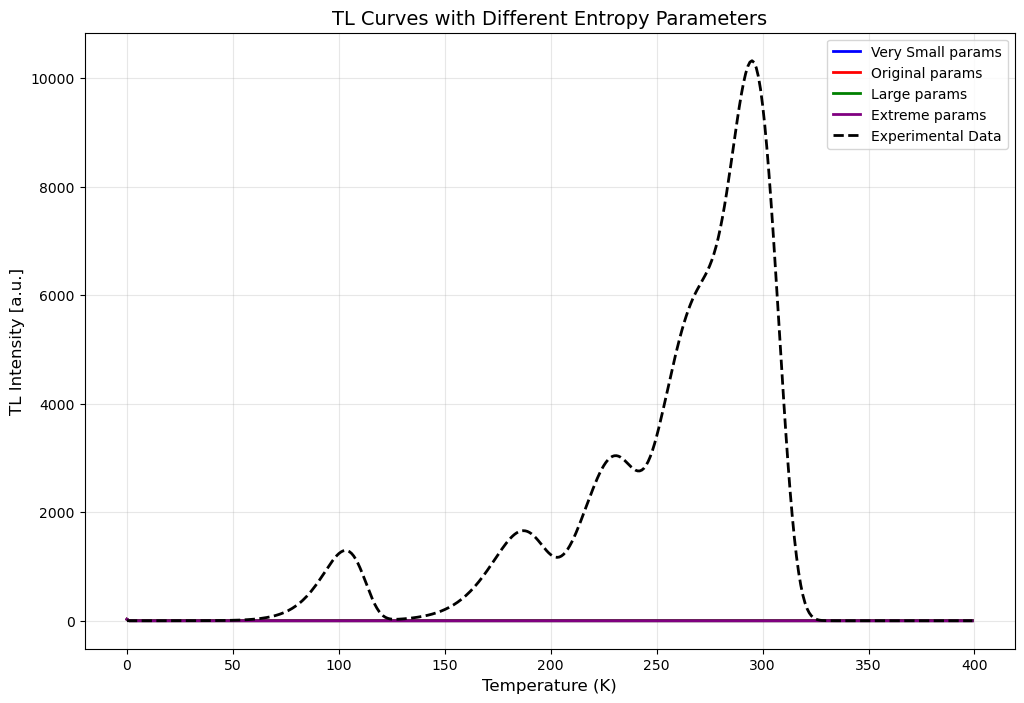


Quantitative comparison (intensity ranges):
Very Small  : Min=-6.33e-16, Max=2.62e+01, Range=2.62e+01
Original    : Min=-6.33e-16, Max=2.62e+01, Range=2.62e+01
Large       : Min=-6.33e-16, Max=2.62e+01, Range=2.62e+01
Extreme     : Min=-6.33e-16, Max=2.62e+01, Range=2.62e+01
Difference from Very Small to Original: 0.00e+00
Difference from Very Small to Large: 0.00e+00
Difference from Very Small to Extreme: 0.00e+00

❌ CONCLUSION: Entropy parameters have minimal effect on TL curve!
   This explains why optimization doesn't improve the fit.
   Consider:
   1. Checking if other parameters need optimization
   2. Verifying the entropy model implementation
   3. Using different experimental data that's more sensitive to entropy

SENSITIVITY ANALYSIS COMPLETE


In [39]:
## DIRECT SENSITIVITY ANALYSIS - DO ENTROPY PARAMETERS MATTER?

print("=" * 70)
print("DIRECT SENSITIVITY ANALYSIS")
print("=" * 70)

# Test: Run simulations with drastically different entropy parameters
# and see if the TL curves are visually different

test_params_sets = [
    [0.1, 1e25, 1e10],     # Very small values
    [1.0, 6.2e27, 1e12],   # Original values  
    [10, 1e30, 1e15],      # Large values
    [50, 1e35, 1e20]       # Extreme values
]

param_names = ["Very Small", "Original", "Large", "Extreme"]

# Store simulation results
all_simulations = []
all_dm_R = []

print("Running simulations with different entropy parameters...")

for i, params in enumerate(test_params_sets):
    print(f"\n{i+1}. Testing {param_names[i]} parameters: a={params[0]}, b={params[1]:.1e}, c={params[2]:.1e}")
    
    try:
        # Create trial value object
        trial_value = SimpleNamespace(
            a=params[0], b=params[1], c=params[2],
            kB=8.617e-5,
            G=0, hr=0, T_C=25,
            N_I=N_I, N_II=N_II, N_III=N_III, N_IV=N_IV, N_V=N_V, N_s=N_s,
            M_R=M_R, M_NR=M_NR,
            A_I=A_I, A_II=A_II, A_III=A_III, A_IV=A_IV, A_V=A_V, A_s=A_s, A_NR=A_NR, A_R=A_R,
            E_I=E_I, E_II=E_II, E_III=E_III, E_IV=E_IV, E_V=E_V, E_s=E_s, E_R_h=E_R_h, E_NR_h=E_NR_h,
            S_I=S_I, S_II=S_II, S_III=S_III, S_IV=S_IV, S_V=S_V, S_s=S_s, S_R_h=S_R_h, S_NR_h=S_NR_h,
            A_mn_NR=A_mn_NR, A_mn_R=A_mn_R
        )
        
        # Run full simulation (abbreviated version)
        # IRRADIATION
        trial_value.T_C = 25
        trial_value.hr = 0
        trial_value.G = 1000
        
        npoints = 1800
        t = np.linspace(0, npoints-1, npoints)
        y0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        
        irradiation = odeint(diff_eqs_freqfactor, y0, t, args=(trial_value,))
        n_I, n_II, n_III, n_IV, n_V, n_s, m_R, m_NR, n_c, n_v = irradiation.T
        
        # HEATING (the part we're comparing)
        trial_value.T_C = 0
        trial_value.hr = 1.0
        trial_value.G = 0
        
        npoints_heat = 400
        t_heat = np.linspace(0, npoints_heat-1, npoints_heat)
        y0_heat = [n_I[-1], n_II[-1], n_III[-1], n_IV[-1], n_V[-1], n_s[-1], m_R[-1], m_NR[-1], n_c[-1], n_v[-1]]
        
        heating = odeint(diff_eqs_freqfactor, y0_heat, t_heat, args=(trial_value,))
        n_I_h, n_II_h, n_III_h, n_IV_h, n_V_h, n_s_h, m_R_h, m_NR_h, n_c_h, n_v_h = heating.T
        
        # Calculate TL intensity
        dm_R_sim = m_R_h * trial_value.A_mn_R * n_c_h
        temp_plot_sim = trial_value.T_C + trial_value.hr * t_heat
        
        all_simulations.append((temp_plot_sim, dm_R_sim))
        all_dm_R.append(dm_R_sim)
        
        # Calculate error vs experimental
        error = np.sum((exp_intensity - dm_R_sim)**2)
        print(f"   Error vs experimental: {error:.2e}")
        
        # Calculate some statistics
        peak_intensity = np.max(dm_R_sim)
        peak_temp = temp_plot_sim[np.argmax(dm_R_sim)]
        print(f"   Peak intensity: {peak_intensity:.2e} at T={peak_temp:.1f}K")
        
    except Exception as e:
        print(f"   SIMULATION FAILED: {e}")

# Compare all simulations visually
if len(all_simulations) > 1:
    print(f"\n\nVisual comparison of {len(all_simulations)} simulations:")
    
    plt.figure(figsize=(12, 8))
    
    # Plot all simulations
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    
    for i, (temp, intensity) in enumerate(all_simulations):
        plt.plot(temp, intensity, label=f'{param_names[i]} params', 
                color=colors[i % len(colors)], linewidth=2)
    
    # Plot experimental data
    plt.plot(temp_plot, exp_intensity, 'k--', linewidth=2, label='Experimental Data')
    
    plt.xlabel('Temperature (K)', fontsize=12)
    plt.ylabel('TL Intensity [a.u.]', fontsize=12)
    plt.title('TL Curves with Different Entropy Parameters', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Quantitative comparison
    print(f"\nQuantitative comparison (intensity ranges):")
    for i, intensity in enumerate(all_dm_R):
        min_val = np.min(intensity)
        max_val = np.max(intensity)
        print(f"{param_names[i]:12}: Min={min_val:.2e}, Max={max_val:.2e}, Range={max_val-min_val:.2e}")
    
    # Check if curves are significantly different
    differences = []
    for i in range(1, len(all_dm_R)):
        diff = np.sum(np.abs(all_dm_R[0] - all_dm_R[i]))
        differences.append(diff)
        print(f"Difference from {param_names[0]} to {param_names[i]}: {diff:.2e}")
    
    if max(differences) < np.sum(np.abs(all_dm_R[0])) * 0.01:  # Less than 1% difference
        print("\n❌ CONCLUSION: Entropy parameters have minimal effect on TL curve!")
        print("   This explains why optimization doesn't improve the fit.")
        print("   Consider:")
        print("   1. Checking if other parameters need optimization")
        print("   2. Verifying the entropy model implementation")
        print("   3. Using different experimental data that's more sensitive to entropy")
    else:
        print("\n✅ CONCLUSION: Entropy parameters DO affect the TL curve")
        print("   The optimization issue might be due to:")
        print("   1. Poor initial guesses")
        print("   2. Local minima in the error function")
        print("   3. Need for longer optimization runs")

else:
    print("Not enough successful simulations for comparison")

print("\n" + "=" * 70)
print("SENSITIVITY ANALYSIS COMPLETE")
print("=" * 70)